In [24]:
!pip install -q datasets soundfile

from datasets import load_dataset, Audio
from itertools import islice
import csv, re

# стрімлю, бо немає стільки пам'яті
ds_stream = load_dataset("google/fleurs", "en_us", split="train", streaming=True)
ds_stream = ds_stream.cast_column("audio", Audio(decode=True))

OUT_CSV = "/content/fleurs_stream_clean.csv"

def clean_text(t: str) -> str:
    t = t.strip().lower()
    t = re.sub(r"[^a-z0-9'.,?!\s]", "", t)
    t = re.sub(r"\s+", " ", t)
    return t.strip()

MAX_ROWS = 2000 # тут можна мінять
MIN_SEC, MAX_SEC = 1.0, 15.0

with open(OUT_CSV, "w", newline="", encoding="utf-8") as f:
    w = csv.writer(f)
    w.writerow(["duration_sec", "text"])
    for ex in islice(ds_stream, MAX_ROWS):
        audio = ex["audio"]
        dur = len(audio["array"]) / audio["sampling_rate"]
        if dur < MIN_SEC or dur > MAX_SEC:
            continue
        txt = clean_text(ex["transcription"])
        w.writerow([f"{dur:.3f}", txt])

print("записано", OUT_CSV)


записано /content/fleurs_stream_clean.csv


In [25]:
import pandas as pd
df = pd.read_csv("/content/fleurs_stream_clean.csv")

df = df.sample(frac=1.0, random_state=42).reset_index(drop=True)
n = len(df)
train_end = int(0.8 * n)
val_end = int(0.9 * n)
df_train = df.iloc[:train_end]
df_val   = df.iloc[train_end:val_end]
df_test  = df.iloc[val_end:]
print(len(df_train), len(df_val), len(df_test))

1453 182 182


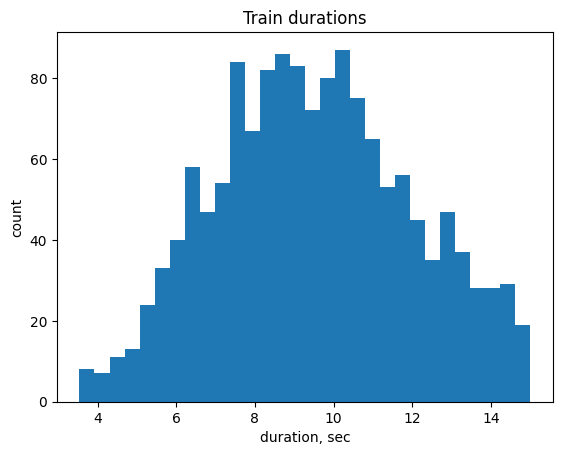

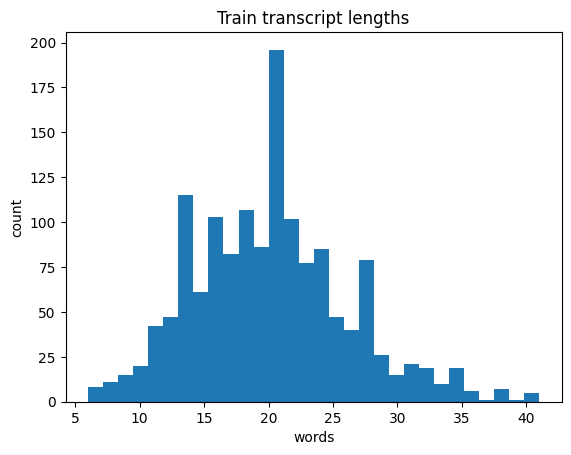

In [26]:
import matplotlib.pyplot as plt
plt.hist(df_train["duration_sec"], bins=30)
plt.xlabel("duration, sec")
plt.ylabel("count")
plt.title("Train durations")
plt.show()

text_len = df_train["text"].str.split().apply(len)
plt.hist(text_len, bins=30)
plt.xlabel("words")
plt.ylabel("count")
plt.title("Train transcript lengths")
plt.show()


In [27]:
# тут щоб послухати можна було
import os, soundfile as sf

PREVIEW_DIR = "/content/fleurs_preview"
os.makedirs(PREVIEW_DIR, exist_ok=True)
ds_stream = load_dataset("google/fleurs", "en_us", split="train", streaming=True)
ds_stream = ds_stream.cast_column("audio", Audio(decode=True))

for i, ex in enumerate(islice(ds_stream, 30)):
    audio = ex["audio"]
    dur = len(audio["array"]) / audio["sampling_rate"]
    if dur < 1.0 or dur > 15.0:
        continue
    path = os.path.join(PREVIEW_DIR, f"sample_{i:03d}.wav")
    sf.write(path, audio["array"], audio["sampling_rate"])
    with open(path + ".txt", "w") as f:
        f.write(ex["transcription"])
print("30 прикладів збережено")


30 прикладів збережено


/tmp/ipython-input-1793505233.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train["split"] = "train"
/tmp/ipython-input-1793505233.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_val["split"] = "validation"
/tmp/ipython-input-1793505233.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.h

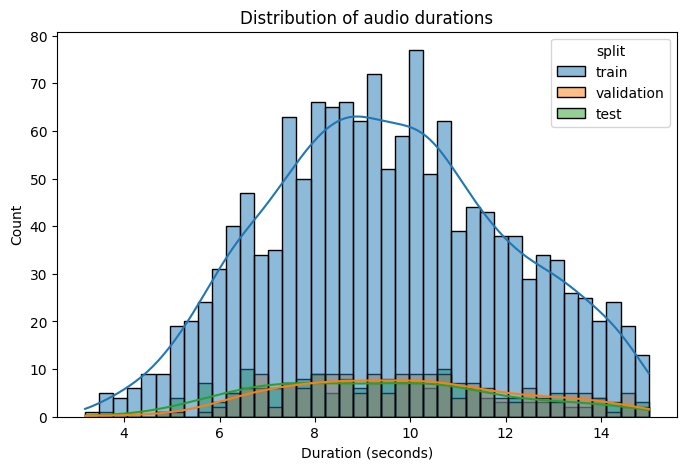

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

df_train["split"] = "train"
df_val["split"] = "validation"
df_test["split"] = "test"
df_all = pd.concat([df_train, df_val, df_test])

plt.figure(figsize=(8,5))
sns.histplot(df_all, x="duration_sec", hue="split", bins=40, kde=True)
plt.title("Distribution of audio durations")
plt.xlabel("Duration (seconds)")
plt.show()


/tmp/ipython-input-748374153.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train["word_count"] = df_train["text"].apply(lambda x: len(str(x).split()))


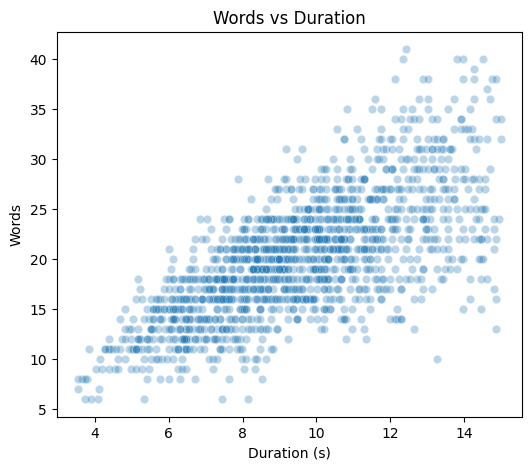

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns
df_train["word_count"] = df_train["text"].apply(lambda x: len(str(x).split()))

plt.figure(figsize=(6,5))
sns.scatterplot(x="duration_sec", y="word_count", data=df_train, alpha=0.3)
plt.xlabel("Duration (s)")
plt.ylabel("Words")
plt.title("Words vs Duration")
plt.show()


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


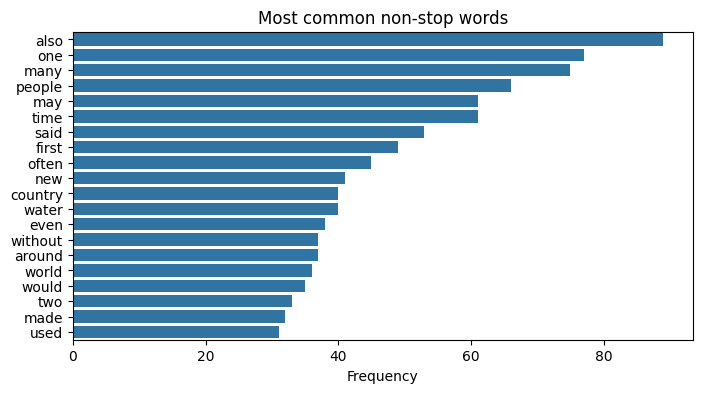

In [30]:
from collections import Counter
import nltk
nltk.download("stopwords")
from nltk.corpus import stopwords

STOPWORDS = set(stopwords.words("english"))

words = " ".join(df_train["text"]).split()
filtered = [w for w in words if w not in STOPWORDS]
counts = Counter(filtered)
common = counts.most_common(20)

plt.figure(figsize=(8,4))
sns.barplot(y=[c[0] for c in common], x=[c[1] for c in common], orient="h")
plt.title("Most common non-stop words")
plt.xlabel("Frequency")
plt.show()


In [31]:
print(df_all["duration_sec"].describe())


count    1817.000000
mean        9.547991
std         2.493266
min         3.180000
25%         7.680000
50%         9.420000
75%        11.280000
max        15.000000
Name: duration_sec, dtype: float64


In [32]:
print("Shortest:", df_train.loc[df_train['duration_sec'].idxmin()]["text"])
print("Longest:", df_train.loc[df_train['duration_sec'].idxmax()]["text"])


Shortest: when the official arrived the apartment exploded
Longest: pureland origami is origami with the restriction that only one fold may be done at a time more complex folds like reverse folds are not allowed and all folds have straightforward locations


/tmp/ipython-input-2368090633.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train["duration_group"] = pd.qcut(df_train["duration_sec"], q=4, labels=["short", "medium", "long", "very long"])
/tmp/ipython-input-2368090633.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="duration_group", y="word_count", data=df_train, palette="Set2")


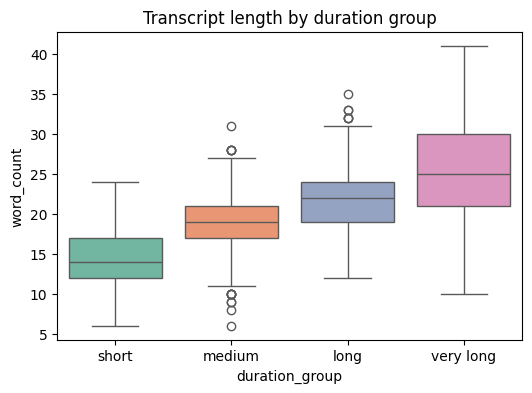

In [33]:
df_train["duration_group"] = pd.qcut(df_train["duration_sec"], q=4, labels=["short", "medium", "long", "very long"])

plt.figure(figsize=(6,4))
sns.boxplot(x="duration_group", y="word_count", data=df_train, palette="Set2")
plt.title("Transcript length by duration group")
plt.show()


### Тут початкове навчання кроки, Але треба дивитись

In [17]:
from datasets import DatasetDict, Dataset
from transformers import WhisperProcessor

from datasets import Audio
ds_all = DatasetDict({
    "train": Dataset.from_pandas(df_train),
    "validation": Dataset.from_pandas(df_val)
})

processor = WhisperProcessor.from_pretrained("openai/whisper-small.en")

def prepare_example(batch):
    audio = batch["audio"]
    inputs = processor.feature_extractor(
        audio["array"], sampling_rate=audio["sampling_rate"], return_tensors="pt"
    )
    labels = processor.tokenizer(batch["text"], return_tensors="pt")
    batch["input_features"] = inputs.input_features[0]
    batch["labels"] = labels.input_ids[0]
    return batch

ds_prepared = ds_all.cast_column("audio", Audio(decode=True))
ds_prepared = ds_prepared.map(prepare_example)


KeyboardInterrupt: 

In [ ]:
from transformers import WhisperForConditionalGeneration, TrainingArguments, Trainer

model = WhisperForConditionalGeneration.from_pretrained("openai/whisper-small.en")

training_args = TrainingArguments(
    output_dir="/content/whisper_en_finetuned",
    per_device_train_batch_size=8,
    evaluation_strategy="steps",
    save_steps=500,
    eval_steps=500,
    learning_rate=1e-5,
    warmup_steps=200,
    max_steps=2000,
    logging_steps=100,
    report_to="none"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=ds_prepared["train"],
    eval_dataset=ds_prepared["validation"],
    tokenizer=processor.feature_extractor,
)

trainer.train()


In [ ]:
import numpy as np
from jiwer import wer

preds = []
refs = []

for ex in ds_prepared["validation"].select(range(50)):
    inputs = processor.feature_extractor(
        ex["audio"]["array"], sampling_rate=ex["audio"]["sampling_rate"], return_tensors="pt"
    )
    pred_ids = model.generate(inputs.input_features)
    text_pred = processor.tokenizer.decode(pred_ids[0], skip_special_tokens=True)
    preds.append(text_pred.lower())
    refs.append(ex["text"].lower())

print("Word Error Rate:", np.mean([wer(r, p) for r, p in zip(refs, preds)]))
